In [1]:
import os
import zipfile
import re
import pandas as pd
import numpy as np
import cv2
from datetime import datetime

In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
#os.environ.keys()

##### Building the dataset for the attributed provides

In [4]:
DATA_DIR = "/home/jupyter/work/data/"
#DATA_DIR = "d:/GoogleDrive/Machine Learning Datasets and models/datasets/CelebA/"
ANNOTATION_DIR = "Anno-20200428T062856Z-001/Anno/"
ANNOTATION_FILE = "list_attr_celeba.txt"
EVAL_DIR = "Eval-20200428T063027Z-001/Eval/"
EVAL_FILE = "list_eval_partition.txt"
IMG_DIR = "celeb_data/train/"

##### Details about annotation file
```
- Attributes Annotations (Anno/list_attr_celeba.txt)
	40 binary attribute labels. See ATTRIBUTE LABELS section below for 
    more info.
=========================
ATTRIBUTE LABELS
=========================
--------------- list_attr_celeba.txt --------------
First Row: number of images
Second Row: attribute names

Rest of the Rows: <image_id> <attribute_labels>
---------------------------------------------------
Notes:
1. The order of attribute labels accords with the order of attribute names;
2. In attribute labels, "1" represents positive while "-1" represents negative.
---------------------------------------------------
```

In [5]:
with open(DATA_DIR + ANNOTATION_DIR + ANNOTATION_FILE,"r") as f:
    anno_file_data = f.readlines()
print("Total lines read : ",len(anno_file_data))

Total lines read :  202601


In [6]:
print(anno_file_data[0],anno_file_data[1])

202599
 5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young 



In [7]:
total_images = int(anno_file_data[0])
column_names = anno_file_data[1].split(" ")[:-1] # last is \n character so ignoring that #

In [8]:
# Building a data frame for annotation data
anno_data_pd = pd.DataFrame([re.sub("\s+"," ",anno_file_data[x]).split(" ")[:-1] for x in range(2,len(anno_file_data))],
                            columns=["filename"] + column_names)

In [9]:
anno_data_pd.head()

,filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [10]:
# Convering +1/-1 to dtype int #
anno_data_pd = pd.concat([anno_data_pd.iloc[:,0],anno_data_pd.iloc[:,1:].astype(int)],axis=1)

In [11]:
# Reading training/ validation / testing data information #
with open(DATA_DIR + EVAL_DIR + EVAL_FILE,"r") as f:
    eval_data = f.readlines()

In [12]:
eval_data_pd = pd.DataFrame([eval_data[x][:-1].split(" ") for x in range(len(eval_data))],columns=["filename","train_val_test"])

In [13]:
eval_data_pd.head()

,filename,train_val_test
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [14]:
anno_data_pd = pd.merge(left=anno_data_pd, right=eval_data_pd,left_on="filename",right_on="filename",how="left")

In [15]:
anno_data_pd = anno_data_pd.assign(train_val_test = anno_data_pd.train_val_test.map({"0" : "train",
                                                                                     "1" : "validation",
                                                                                     "2" : "test"}))

In [16]:
anno_data_pd.head()

,filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,train_val_test
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,1,1,-1,1,-1,1,-1,-1,1,train
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,1,train
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,1,train
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,-1,1,1,-1,1,train
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,1,train


In [17]:
img = cv2.imread(DATA_DIR + IMG_DIR + "000001.jpg")
img.shape

(218, 178, 3)

In [18]:
from tensorflow.keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import UpSampling2D, Conv2DTranspose, MaxPool2D, Dense,Input, Flatten, Reshape, Lambda, LeakyReLU, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# For plotting model graph
from tensorflow.keras.utils import plot_model
import tensorflow as tf

In [19]:
tf.compat.v1.disable_eager_execution()

In [ ]:
vgg19_model = VGG19(weights="imagenet",include_top=False)
vgg19_model.trainable = False

In [21]:
vgg19_model.predict(img.reshape(1,218,178,3)).shape

(1, 6, 5, 512)

#### Building the Encoder Model

In [22]:
embedding_dim = 128

In [23]:
# Get VGG's last layer output #
vgg19_output = vgg19_model.get_layer("block5_pool").output

# Reshape it as per sample output shape seen above
vgg19_output = Reshape((15360,),name="encoder_reshape_layer")(vgg19_output)

# Building the mean layer
mu_output = Dense(embedding_dim,name="mu_layer")(vgg19_output)

# building the log_var layer
log_var_output = Dense(embedding_dim,name="log_var_layer")(vgg19_output)

# sampling from a standard normal distribution, forcing the representation
def sampling(args):
    mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mu), mean=0, stddev=1.0)
    return mu + K.exp(log_var/2) * epsilon

encoder_output = Lambda(sampling,name="encoder_output")([mu_output,log_var_output])

In [24]:
mu_log_var_model = Model(inputs=vgg19_model.input,outputs=[mu_output,log_var_output])

In [25]:
encoder_model = Model(inputs=vgg19_model.input, outputs=encoder_output)

#### Building the decoder

In [26]:
img.shape

(218, 178, 3)

In [27]:
decoder_input = Input(shape=(embedding_dim,),name="decoder_input")
x = decoder_input
x = Dense(15360,name="decoder_dense")(decoder_input)
x = Reshape((6,5,512),name="decoder_reshape")(x)

x = Conv2DTranspose(512,strides=2,kernel_size=(2,2),name="decoder_blk-1_2dtran-1")(x)           # output (12,10)
x = LeakyReLU()(x)
x = Conv2DTranspose(512,strides=1,kernel_size=(2,2),name="decoder_blk-1_2dtran-2")(x)           # output (13,11)
x = LeakyReLU()(x)
x = Conv2DTranspose(512,strides=2,kernel_size=(2,2),name="decoder_blk-1_2dtran-3")(x)           # output (26,22)
x = LeakyReLU()(x)

# Special group, to increase the size of 1 axis - same channel #
x = Conv2DTranspose(512,strides=1,kernel_size=(2,1),name="decoder_blk-sp_2dtran-1")(x)           # output (27,22)
x = LeakyReLU()(x)

# Reduce channel - same size
x = Conv2DTranspose(256,strides=1,kernel_size=(1,1),name="decoder_blk-2_2dtran-1")(x)           # output (27,22)
x = LeakyReLU()(x)
# Reduce channel - same size
x = Conv2DTranspose(128,strides=1,kernel_size=(1,1),name="decoder_blk-2_2dtran-2")(x)           # output (27,22)
x = LeakyReLU()(x)
# Same Channel - increase size
x = Conv2DTranspose(128,strides=2,kernel_size=(2,2),name="decoder_blk-2_2dtran-3")(x)           # output (54,44)
x = LeakyReLU()(x)

# Reduce channel - same size
x = Conv2DTranspose(64,strides=1,kernel_size=(1,1),name="decoder_blk-3_2dtran-1")(x)           # output (54,44)
x = LeakyReLU()(x)
# Reduce channel - same size
x = Conv2DTranspose(32,strides=1,kernel_size=(1,1),name="decoder_blk-3_2dtran-2")(x)           # output (54,44)
x = LeakyReLU()(x)
# Same Channel - increase size
x = Conv2DTranspose(32,strides=2,kernel_size=(2,2),name="decoder_blk-3_2dtran-3")(x)           # output (108,88)
x = LeakyReLU()(x)

# Special group, to increase the size of 1 axis - same channel #
x = Conv2DTranspose(32,strides=1,kernel_size=(2,2),name="decoder_blk-sp_2dtran-2")(x)           # output (109,89)
x = LeakyReLU()(x)

# Reduce Channel - same size
x = Conv2DTranspose(16,strides=1,kernel_size=(1,1),name="decoder_blk-4_2dtran-1")(x)           # output (109,89)
x = LeakyReLU()(x)
# Reduce channel - same size
x = Conv2DTranspose(8,strides=1,kernel_size=(1,1),name="decoder_blk-4_2dtran-2")(x)            # output (109,89)
x = LeakyReLU()(x)
# Same Channel - increase size
x = Conv2DTranspose(8,strides=2,kernel_size=(2,2),name="decoder_blk-4_2dtran-3")(x)           # output (218,178)
x = LeakyReLU()(x)
# Reduce channel - same size
x = Conv2DTranspose(3,strides=1,kernel_size=(1,1),name="decoder_blk-4_2dtran-4")(x)           # output (218,178)

# final activation
x = Activation("sigmoid")(x)
decoder_output = x

In [28]:
decoder_model = Model(inputs=decoder_input,outputs=decoder_output)

In [29]:
complete_input = encoder_model.input
complete_output = decoder_model(encoder_model.output)
complete_model = Model(inputs=complete_input,outputs=complete_output)

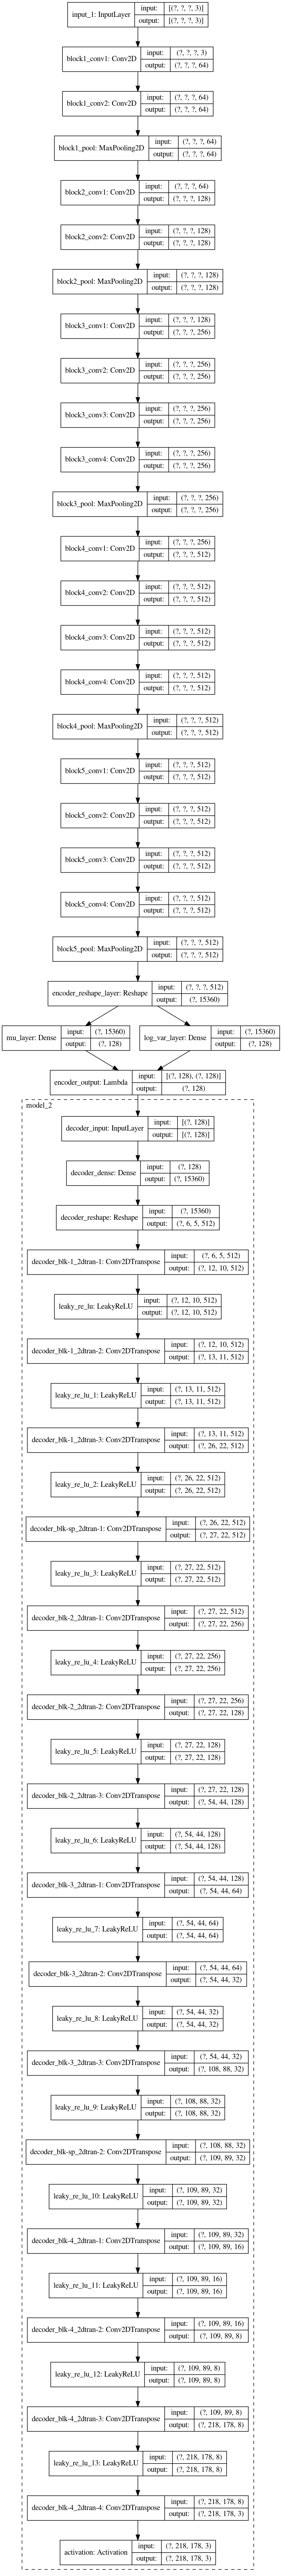

In [30]:
plot_model(complete_model,expand_nested=True,show_shapes=True)

In [31]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 10000

model_name = "vae_vgg19"
reduce_LR_patience = 5
curr_dt_time = datetime.now()

In [32]:
def vae_r_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return R_LOSS_FACTOR * r_loss

def vae_kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var_output - K.square(mu_output) - K.exp(log_var_output), axis = 1)
    return kl_loss

def vae_loss(y_true, y_pred):
    r_loss = vae_r_loss(y_true,y_pred)
    kl_loss = vae_kl_loss(y_true, y_pred)
    return  r_loss + kl_loss

complete_model.compile(optimizer=Adam(lr=LEARNING_RATE),
                       loss=vae_loss,
                       metrics=[vae_r_loss,vae_kl_loss],
                       experimental_run_tf_function=False)

In [33]:
model_name = model_name + "_" + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{vae_r_loss:.5f}-{val_loss:.5f}-{val_vae_r_loss:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=False, 
                             save_weights_only=False, 
                             mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                       patience=reduce_LR_patience, min_lr=0.0001,verbose=1)

callbacks_list = [checkpoint, LR]
#callbacks_list = [checkpoint]
#callbacks_list = []
print(model_name)

vae_vgg19_2020-05-0904_37_57.712756/


In [34]:
k_data_gen = image.ImageDataGenerator(rescale=1/255)

In [35]:
print("Train size : %d\nval size : %d\ntest size : %d" %(anno_data_pd[anno_data_pd.train_val_test == "train"].shape[0],
                                                         anno_data_pd[anno_data_pd.train_val_test == "validation"].shape[0],
                                                         anno_data_pd[anno_data_pd.train_val_test == "test"].shape[0]))

Train size : 162770
val size : 19867
test size : 19962


In [36]:
train_data_size = 100000
validation_data_size = anno_data_pd[anno_data_pd.train_val_test == "validation"].shape[0]

batch_size = 32

train_steps = int(train_data_size / batch_size) if train_data_size % batch_size == 0 \
              else int((train_data_size // batch_size) + 1)
validation_steps = int(validation_data_size / batch_size) if validation_data_size % batch_size == 0 \
                   else int((validation_data_size // batch_size) + 1)

EPOCHS = 20

print("train steps : %d, val steps : %d\nbatch size : %d, EPOCHS : %d" %(train_steps,
                                                                         validation_steps,
                                                                         batch_size,
                                                                         EPOCHS))

train steps : 3125, val steps : 621
batch size : 32, EPOCHS : 20


In [37]:
train_gen = k_data_gen.flow_from_dataframe(dataframe=anno_data_pd[anno_data_pd.train_val_test == 'train'].iloc[0:train_data_size,:][["filename"]],
                                           directory=DATA_DIR + IMG_DIR,
                                           class_mode="input",
                                           batch_size=batch_size,
                                           shuffle=True,
                                           seed=42,
                                           target_size=(img.shape[0],img.shape[1]))

Found 100000 validated image filenames.


In [38]:
val_gen = k_data_gen.flow_from_dataframe(dataframe=anno_data_pd[anno_data_pd.train_val_test == 'validation'].iloc[0:validation_data_size,:][["filename"]],
                                           directory=DATA_DIR + IMG_DIR,
                                           class_mode="input", # we want the output image to same as input image
                                           batch_size=batch_size,
                                           shuffle=True,
                                           seed=42,
                                           target_size=(img.shape[0],img.shape[1]))

Found 19867 validated image filenames.


In [39]:
model_training = complete_model.fit_generator(train_gen,epochs=EPOCHS,
                                              steps_per_epoch=train_steps,
                                              validation_steps=validation_steps,
                                              validation_data=val_gen,callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
3125/3125 [==============================] - ETA: 0s - loss: 504.3435 - vae_r_loss: 437.3925 - vae_kl_loss: 66.9507
Epoch 00001: saving model to vae_vgg19_2020-05-0904_37_57.712756/model-00001-504.34347-437.39249-437.10403-369.30029.h5
3125/3125 [==============================] - 1119s 358ms/step - loss: 504.3435 - vae_r_loss: 437.3925 - vae_kl_loss: 66.9507 - val_loss: 437.1040 - val_vae_r_loss: 369.3003 - val_vae_kl_loss: 67.7945 - lr: 5.0000e-04
Epoch 2/20
3125/3125 [==============================] - ETA: 0s - loss: 420.5182 - vae_r_loss: 349.5829 - vae_kl_loss: 70.9357
Epoch 00002: saving model to vae_vgg19_2020-05-0904_37_57.712756/model-00002-420.51823-349.58286-417.08948-347.14337.h5
3125/3125 [==============================] - 948s 303ms/step - loss: 420.5182 - vae_r_loss: 349.5829 - vae_kl_loss: 70.9357 - val_loss: 417.0895 - val_vae_r_loss: 347.1434 - val_vae_kl_loss: 69.9542 - lr: 5.0000e-